In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import TimeSeriesDataset
from models import MLR, MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Generate a synthetic time-series data

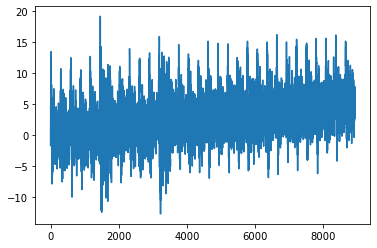

In [111]:
# fig=plt.figure(figsize=(16, 12))
x = np.linspace(0, 2*np.pi, 288)

total_days = 31
trend_slope = 5
noise_coef = 2
noise_coef_outlier = 4

signal = []
for _ in range(total_days):
    n = noise_coef * np.random.randn(len(x))
    if np.random.choice(7) == 0:
        n += noise_coef_outlier * np.random.randn(len(x))
    y = 10 * np.sin(4 * x) * np.exp(-0.5 * x) + n
    signal.append(y)
signal = np.hstack(signal)

trend = trend_slope * np.linspace(0, 1, len(signal))
signal += trend
x = np.arange(len(signal))

regressor = trend + np.cos(.0005 * x) + 0.1 * np.random.randn(len(trend))

plt.plot(signal)

In [112]:
stl = STL(signal[:-288], period=288, seasonal=7)
stl_result = stl.fit()

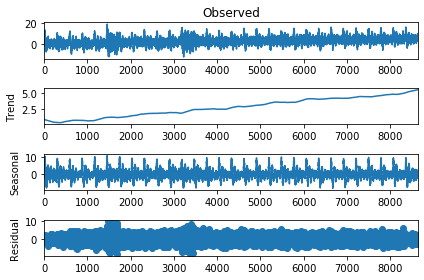

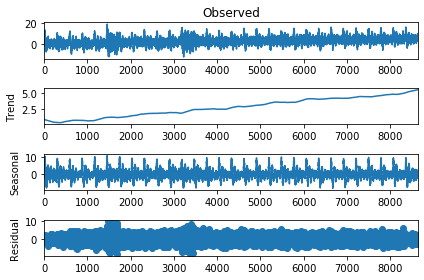

In [113]:
stl_result.plot()

In [114]:
seasonal = stl_result.seasonal
trend = stl_result.trend

In [115]:
train_labels = signal[:-288]
train_data = np.hstack([seasonal.reshape(-1, 1), trend.reshape(-1, 1)])
test_labels = signal[-288:]
test_data = np.hstack([seasonal[-288:].reshape(-1, 1), (trend[-1] - trend[-288]) + trend[-288:].reshape(-1, 1)])
train_data.shape, test_data.shape

((8640, 2), (288, 2))

In [116]:
train_loader = DataLoader(TimeSeriesDataset(train_data, train_labels), batch_size=16, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(test_data, test_labels), batch_size=16, shuffle=False)

## Training Model and Configuration

In [117]:
model = MLR(input_size=train_data.shape[1], nclasses=1, hidden_layers=[100], dropout=0.5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.005)
model.net

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Dropout(p=0.5, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=1, bias=True)
)

In [118]:
loss_vec = []
reset_loss_every = 300
n_epochs = 10
device = "cpu"
model.to(device)
model.train()

for epoch in range(n_epochs):
    for it, batch in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = batch
        output = model(data.float().to(device))
        loss = F.mse_loss(output, target.view(-1, 1).to(device))
        loss_vec.extend([loss.item()])
        loss.backward()
        optimizer.step()
        
        if (it % reset_loss_every) == 0:
            print(f"epoch: {epoch}, it: {it}, average_loss: {np.mean(loss_vec)}")
            loss_vec = []


epoch: 0, it: 0, average_loss: 17.522859573364258
epoch: 0, it: 300, average_loss: 5.4260964882373806
epoch: 1, it: 0, average_loss: 4.243777420123418
epoch: 1, it: 300, average_loss: 4.050629161993663
epoch: 2, it: 0, average_loss: 3.9653224537769955
epoch: 2, it: 300, average_loss: 3.8865374473730725
epoch: 3, it: 0, average_loss: 3.9528339490294457
epoch: 3, it: 300, average_loss: 3.90452339609464
epoch: 4, it: 0, average_loss: 3.836483252545198
epoch: 4, it: 300, average_loss: 3.888970590829849
epoch: 5, it: 0, average_loss: 3.814507463077704
epoch: 5, it: 300, average_loss: 3.8508980602025984
epoch: 6, it: 0, average_loss: 3.8945955840249855
epoch: 6, it: 300, average_loss: 3.8461529288689293
epoch: 7, it: 0, average_loss: 3.7184812642633913
epoch: 7, it: 300, average_loss: 3.7086652477582294
epoch: 8, it: 0, average_loss: 3.969007058441639
epoch: 8, it: 300, average_loss: 3.8780345817406974
epoch: 9, it: 0, average_loss: 3.8372058014074963
epoch: 9, it: 300, average_loss: 3.88152

Test mse_loss = 91.4276777903239


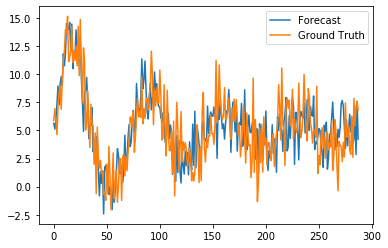

In [119]:
loss_vec = []
forecast = []
gt = []
model.eval()
for it, batch in enumerate(test_loader):
    data, target = batch
    output = model(data.float().to(device))
    loss = F.mse_loss(output, target.view(-1, 1).to(device), reduction='sum')
    forecast.append(output.view(-1).data.numpy())
    gt.append(target.view(-1).data.numpy())
    loss_vec.append(loss.item())
forecast = np.hstack(forecast)
gt = np.hstack(gt)
print(f"Test mse_loss = {sum(loss_vec)/len(test_loader)}")
plt.plot(forecast, label="Forecast")
plt.plot(gt, label="Ground Truth")
plt.legend()